In [1]:
import torch

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
print(device)

cpu


In [4]:
import pandas as pd

In [5]:
!wget https://www.dropbox.com/scl/fo/vlylepcshq46ytwfdy9bq/AEykvkXwsYY_L4HrdLwFMkU?rlkey=n4s44wyj8wal5inty51vfu1zr&st=9vl2ntfi&dl=0 data/

/bin/bash: line 1: data/: No such file or directory
--2024-04-29 19:43:24--  https://www.dropbox.com/scl/fo/vlylepcshq46ytwfdy9bq/AEykvkXwsYY_L4HrdLwFMkU?rlkey=n4s44wyj8wal5inty51vfu1zr
Resolving www.dropbox.com (www.dropbox.com)... 162.125.4.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.4.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc88f138507960c17220908a8d73.dl.dropboxusercontent.com/zip_download_get/B1U39LcNpcMjGGgNR_o_YvzJoXT8jHIC0Mr5BWIXTroM_zEbHfgB1u7a2oDmFfzPr9y0eMYABK6fiiMJboSlMYIcZZyzA4A9zbjkV_obCWwOSQ# [following]
--2024-04-29 19:43:25--  https://uc88f138507960c17220908a8d73.dl.dropboxusercontent.com/zip_download_get/B1U39LcNpcMjGGgNR_o_YvzJoXT8jHIC0Mr5BWIXTroM_zEbHfgB1u7a2oDmFfzPr9y0eMYABK6fiiMJboSlMYIcZZyzA4A9zbjkV_obCWwOSQ
Resolving uc88f138507960c17220908a8d73.dl.dropboxusercontent.com (uc88f138507960c17220908a8d73.dl.dropboxusercontent.com)... 162.125.6.15, 2620:100:6019:15::a27d:40f


In [6]:
!unzip AEykvkXwsYY_L4HrdLwFMkU?rlkey=n4s44wyj8wal5inty51vfu1zr&st=9vl2ntfi&dl=0 data/

/bin/bash: line 1: data/: No such file or directory
Archive:  AEykvkXwsYY_L4HrdLwFMkU?rlkey=n4s44wyj8wal5inty51vfu1zr
mapname:  conversion of  failed
   creating: combined/
   creating: datasets/
   creating: embeddings/
 extracting: build_data.py           
 extracting: build_datasets.py       
 extracting: datasets/Wu_test.pt     
 extracting: combined/Wu_test.csv    
 extracting: datasets/Wu_train.pt    
 extracting: combined/Wu_train.csv   
 extracting: datasets/Chen_test.pt   
 extracting: combined/Chen_test.csv  
 extracting: datasets/Chen_train.pt  
 extracting: datasets/Olson_test.pt  
 extracting: datasets/Sinai_test.pt  
 extracting: combined/Olson_test.csv  
 extracting: combined/Sinai_test.csv  
 extracting: combined/Chen_train.csv  
 extracting: datasets/Olson_train.pt  
 extracting: datasets/Sinai_train.pt  
 extracting: combined/Sinai_train.csv  
 extracting: combined/Olson_train.csv  
 extracting: embeddings/Wu_test_seq.pt  
 extracting: datasets/Pokusaeva_test.pt  
 ex

In [7]:
!git clone https://github.com/rahikot/MLBProject.git

Cloning into 'MLBProject'...
remote: Enumerating objects: 166, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 166 (delta 4), reused 35 (delta 3), pack-reused 129
Receiving objects: 100% (166/166), 64.22 MiB | 20.58 MiB/s, done.
Resolving deltas: 100% (31/31), done.


In [61]:
from MLBProject.rank_n_contrast.model import RepresentationEncoder

X_emb = torch.load('embeddings/Olson_train_seq.pt', map_location=device)
y = pd.read_csv('combined/Olson_train.csv')['DMS_score']
model = RepresentationEncoder()
model.load_state_dict(torch.load('/content/MLBProject/rank_n_contrast/save/Olson_models/RnC_Olson_RepEnc_ep_200_lr_0.0003_d_0.1_wd_0.0001_mmt_0.5_bsz_256_aug_crop,flip,color,grayscale_temp_2_label_l1_feature_l2_trial_0/curr_last.pth', map_location=device)['model'])
model.eval()

RepresentationEncoder(
  (lin1): Linear(in_features=320, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=10, bias=True)
  (tanh): Tanh()
)

In [62]:
import matplotlib.pyplot as plt

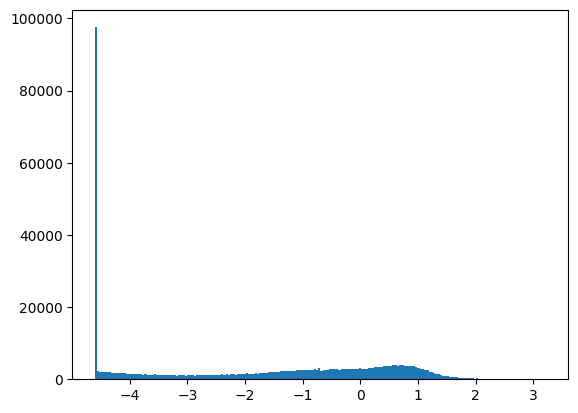

In [63]:
plt.hist(y, bins=200)
plt.show()

In [64]:
import sklearn

import numpy as np
from sklearn.linear_model import LinearRegression

print(np.array(y).shape)

(429569,)


In [65]:
X = model(X_emb.cpu())
lin_reg = LinearRegression()
lin_reg.fit(X.detach().numpy(), np.array(y))

LinearRegression()

In [68]:
test_X = torch.load('embeddings/Olson_test_seq.pt', map_location=device)
test_y = pd.read_csv('combined/Olson_test.csv')['DMS_score']
predictions = lin_reg.predict(model(test_X.cpu()).detach().numpy())

In [69]:
from scipy.stats import spearmanr

coef, p = spearmanr(np.array(test_y), predictions)
print(coef)

0.4616370176795258


In [70]:
def minmax(x):
    return ( (x - np.min(x)) / (np.max(x) - np.min(x)) )

def calc_ndcg(y_true, y_score, **kwargs):
    '''
    Inputs:
        y_true: an array of the true scores where higher score is better
        y_score: an array of the predicted scores where higher score is better
    Options:
        quantile: If True, uses the top k quantile of the distribution
        top: under the quantile setting this is the top quantile to
            keep in the gains calc. This is a PERCENTAGE (i.e input 10 for top 10%)
    Notes:
        Currently we're calculating NDCG on the continuous value of the DMS
        I tried it on the binary value as well and the metrics seemed mostly
        the same.
    '''
    if 'quantile' not in kwargs:
        kwargs['quantile'] = True
    if 'top' not in kwargs:
        kwargs['top'] = 10
    if kwargs['quantile']:
        k = np.floor(y_true.shape[0]*(kwargs['top']/100)).astype(int)
    else:
        k = kwargs['top']
    if isinstance(y_true, pd.Series):
        y_true = y_true.values
    if isinstance(y_score, pd.Series):
        y_score = y_score.values
    gains = minmax(y_true)
    ranks = np.argsort(np.argsort(-y_score)) + 1

    if k == 'all':
        k = len(ranks)
    #sub to top k
    ranks_k = ranks[ranks <= k]
    gains_k = gains[ranks <= k]
    #all terms with a gain of 0 go to 0
    ranks_fil = ranks_k[gains_k != 0]
    gains_fil = gains_k[gains_k != 0]

    #if none of the ranks made it return 0
    if len(ranks_fil) == 0:
        return (0)

    #discounted cumulative gains
    dcg = np.sum([g/np.log2(r+1) for r,g in zip(ranks_fil, gains_fil)])

    #ideal dcg - calculated based on the top k actual gains
    ideal_ranks = np.argsort(np.argsort(-gains)) + 1
    ideal_ranks_k = ideal_ranks[ideal_ranks <= k]
    ideal_gains_k = gains[ideal_ranks <= k]
    ideal_ranks_fil = ideal_ranks_k[ideal_gains_k != 0]
    ideal_gains_fil = ideal_gains_k[ideal_gains_k != 0]
    idcg = np.sum([g/np.log2(r+1) for r,g in zip(ideal_ranks_fil, ideal_gains_fil)])

    #normalize
    ndcg = dcg/idcg

    return (ndcg)
def calc_toprecall(true_scores, model_scores, top_true=10, top_model=10):
    top_true = (true_scores >= np.percentile(true_scores, 100-top_true))
    top_model = (model_scores >= np.percentile(model_scores, 100-top_model))

    TP = (top_true) & (top_model)
    recall = TP.sum() / (top_true.sum())

    return (recall)

In [71]:
print(calc_ndcg(test_y, predictions))
print(calc_toprecall(test_y, predictions))

0.7570334997810324
0.23156424581005586


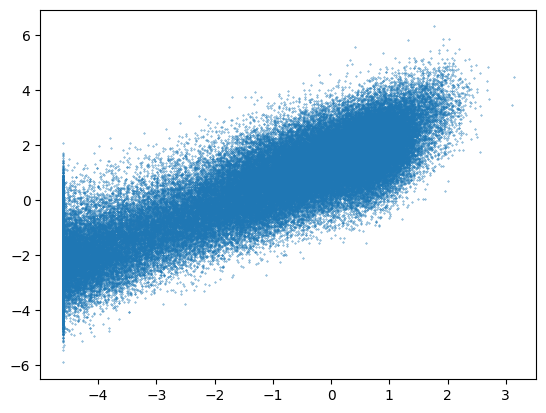

In [75]:
plt.scatter(test_y, test_y - predictions, s=0.1)
plt.show()